In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image


In [3]:
original_img_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')


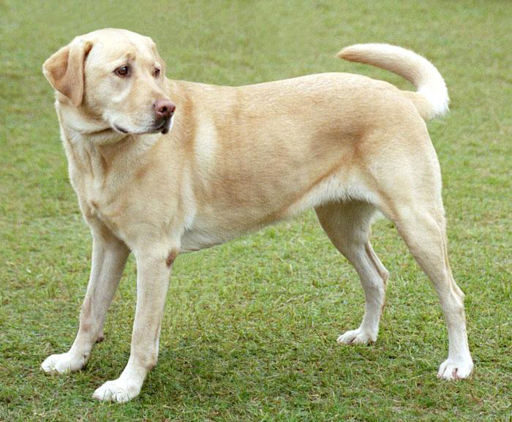

In [65]:
def load_img(img_path):
    img = PIL.Image.open(img_path)
    img.thumbnail((512, 512))
    return np.array(img, dtype=np.float32)

def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

def show(img):
    display_img = np.array(img, dtype=np.uint8)
    display.display(PIL.Image.fromarray(display_img))

original_img = load_img(original_img_path)
show(original_img)

In [243]:
base_model = keras.applications.InceptionV3(include_top=False, weights='imagenet')
names = ['mixed3', 'mixed5']
names = ['mixed5']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

In [244]:
def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    
    if(len(layer_activations) == 1):
        layer_activations = [layer_activations]
        
    losses = []
    for layer_activation in layer_activations:
        losses.append(tf.reduce_mean(layer_activation))
        
    return tf.reduce_sum(losses)

In [245]:
def random_roll(img, maxroll):
    axis_shift = tf.cast(tf.random.uniform(shape=[2], maxval = maxroll * 2) - maxroll, dtype=tf.int32)
    shift_down = axis_shift[0]
    shift_right = axis_shift[1]
    temp_img = tf.roll(tf.roll(img, shift_down, axis=0), shift_right, axis=1)
    return temp_img, shift_down, shift_right

class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
    @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size = 0.01):
        img, shift_down, shift_right = random_roll(img, 150)
        loss = tf.constant(0.0)
        gradients = img
        
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)
            gradients = tape.gradient(loss, img)
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            img = img + step_size*gradients
            img = tf.clip_by_value(img, -1, 1)

        img = tf.roll(tf.roll(img, -shift_down, axis=0), -shift_right, axis=1)

        return loss, img, gradients
    
dream_class = DeepDream(dream_model)

In [246]:
def run_deep_dream_simple(img, steps=100, step_size = 0.01):
    img = tf.convert_to_tensor(img)
    
    max_steps = 10
    epochs = steps//max_steps
    
    for epoch in range(epochs):
        loss, img, gradients = dream_class(img, tf.constant(max_steps), tf.constant(step_size))
        display.clear_output(wait=True)
        print("epoch:", epoch+1, "loss:", loss, "img mean:", tf.reduce_mean(img))
        print("gradients ----")
        print("min:", tf.reduce_min(gradients))
        print("mean:", tf.reduce_mean(gradients))
        print("std:", tf.math.reduce_std(gradients))
        print("max:", tf.reduce_max(gradients))
        print("gradients/std ----")
        print("min:", tf.reduce_min  (gradients/tf.math.reduce_std(gradients)))
        print("mean:", tf.reduce_mean(gradients/tf.math.reduce_std(gradients)))
        print("max:", tf.reduce_max  (gradients/tf.math.reduce_std(gradients)))
        show(deprocess(img))
        
    return img

epoch: 10 loss: tf.Tensor(0.72038764, shape=(), dtype=float32) img mean: tf.Tensor(0.17316312, shape=(), dtype=float32)
gradients ----
min: tf.Tensor(-14.696351, shape=(), dtype=float32)
mean: tf.Tensor(-0.000648194, shape=(), dtype=float32)
std: tf.Tensor(0.99943936, shape=(), dtype=float32)
max: tf.Tensor(17.15384, shape=(), dtype=float32)
gradients/std ----
min: tf.Tensor(-14.704595, shape=(), dtype=float32)
mean: tf.Tensor(-0.00064855686, shape=(), dtype=float32)
max: tf.Tensor(17.163462, shape=(), dtype=float32)


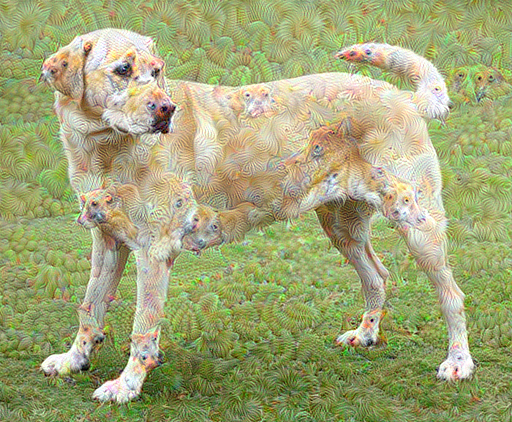

<tf.Tensor: shape=(422, 512, 3), dtype=float32, numpy=
array([[[ 0.2516817 ,  0.29576543, -0.19625156],
        [ 0.33235106,  0.37596503, -0.17544685],
        [ 0.29211497,  0.41226923, -0.1646948 ],
        ...,
        [ 0.02410703,  0.14802344, -0.27259138],
        [-0.1017525 ,  0.13351241, -0.3244378 ],
        [ 0.01147366,  0.22522077, -0.36136457]],

       [[ 0.18963526,  0.14326786, -0.21980819],
        [ 0.2089166 ,  0.2439324 , -0.18462048],
        [ 0.29796344,  0.3702009 , -0.11723996],
        ...,
        [-0.01866306,  0.17991717, -0.2690537 ],
        [ 0.01308145,  0.1456741 , -0.27452213],
        [ 0.10156273,  0.19252014, -0.2769658 ]],

       [[ 0.1626793 ,  0.291358  , -0.19041099],
        [ 0.14032531,  0.22343428, -0.23070373],
        [ 0.23486535,  0.1310404 , -0.25045246],
        ...,
        [ 0.01889157,  0.15770651, -0.27203128],
        [ 0.11816668,  0.15665583, -0.23391785],
        [ 0.16934767,  0.21649428, -0.21856517]],

       ...,

     

In [247]:
original_img = load_img(original_img_path)
img = tf.constant(original_img)
img = keras.applications.inception_v3.preprocess_input(img)
run_deep_dream_simple(img, 100, 0.01)

epoch: 10 loss: tf.Tensor(0.9925855, shape=(), dtype=float32) img mean: tf.Tensor(0.15847443, shape=(), dtype=float32)
gradients ----
min: tf.Tensor(-22.112942, shape=(), dtype=float32)
mean: tf.Tensor(-0.0015033003, shape=(), dtype=float32)
std: tf.Tensor(0.99917364, shape=(), dtype=float32)
max: tf.Tensor(21.867098, shape=(), dtype=float32)
gradients/std ----
min: tf.Tensor(-22.13123, shape=(), dtype=float32)
mean: tf.Tensor(-0.001504543, shape=(), dtype=float32)
max: tf.Tensor(21.885183, shape=(), dtype=float32)


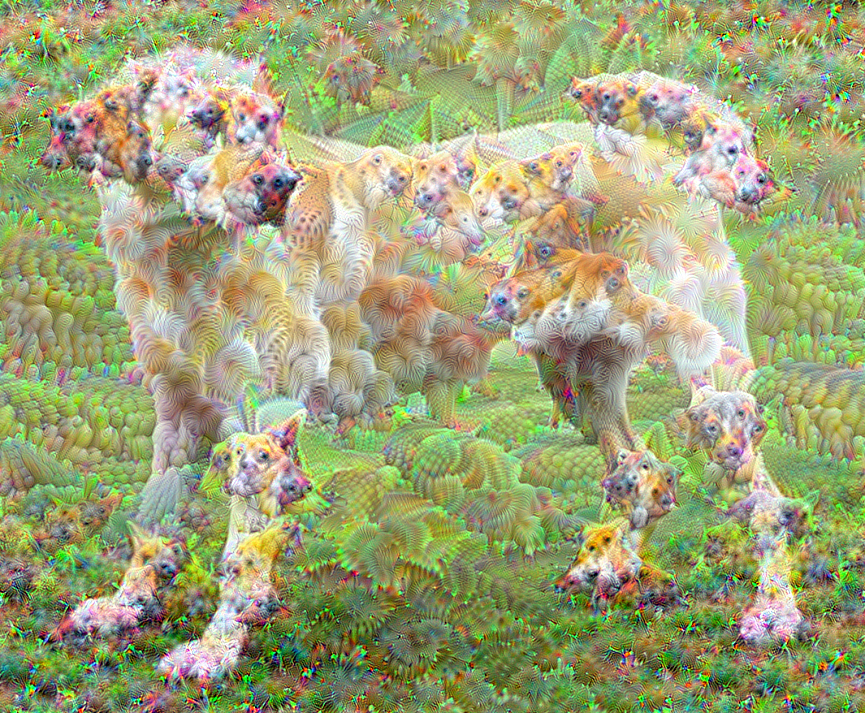

In [248]:
original_img = load_img(original_img_path)
img = tf.constant(original_img)
img = keras.applications.inception_v3.preprocess_input(img)
base_size = tf.shape(original_img)[:-1]
OCTAVE_SCALE = 1.3

for n in range(-2,3):
    new_size = tf.cast(tf.cast(base_size, dtype=tf.float32) * (OCTAVE_SCALE ** n), dtype=tf.int32)
    print("calculated size:", new_size)
    img = tf.image.resize(img, new_size)
    print("original size:", original_img.shape)
    print("new      size:", img.shape)
    img = run_deep_dream_simple(img, 100, 0.01)
    
    